# Testing the Neuro-Fuzzy Classifier with the Iris Dataset
This notebook uses the Iris dataset to test that the neuro-fuzzy classifier model is working correctly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

iris = datasets.load_iris()
X, classes = iris.data, iris.target

# convert target to one hot vectors
Y = np.zeros((150, 3))
Y[np.arange(150), classes] = 1

The dataset is loaded from the sklearn library.

In [2]:
import os
import pickle
from umap import UMAP

_cache_dir = "cache/umap.pickle"
_ignore_cache = False

if not os.path.isfile(_cache_dir) or _ignore_cache:
    umap_reducer = UMAP(random_state=42).fit(X)
    pickle.dump(umap_reducer, open(_cache_dir, "wb"))
else:
    umap_reducer = pickle.load(open(_cache_dir, "rb"))

umap_data = umap_reducer.transform(X)

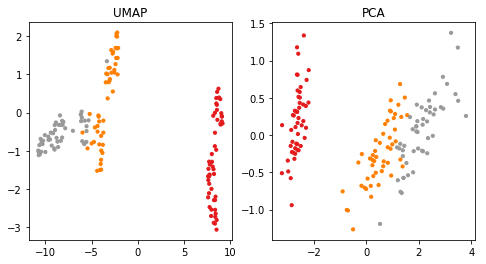

In [3]:
from sklearn.decomposition import PCA

_cache_dir = "cache/pca.pickle"
_ignore_cache = False

if not os.path.isfile(_cache_dir) or _ignore_cache:
    pca_reducer = PCA(n_components=2, random_state=42).fit(X)
    pickle.dump(pca_reducer, open(_cache_dir, "wb"))
else:
    pca_reducer = pickle.load(open(_cache_dir, "rb"))

pca_data = pca_reducer.transform(X)

fig, axes = plt.subplots(1, 2, figsize=(8,4), squeeze=True)
axes[0].set_title("UMAP")
axes[0].scatter(umap_data[:,0], umap_data[:,1], s=10, c=classes, cmap='Set1')
axes[1].set_title("PCA")
axes[1].scatter(pca_data[:,0], pca_data[:,1], s=10, c=classes, cmap='Set1')

#plt.colorbar(boundaries=np.arange(4)-0.5).set_ticks(np.arange(3))

A UMAP and PCA embedding are created to visualize the data and the clusters in 2 dimensions.

In [4]:
import keras
import keras.layers as layers
import keras.models as models
from keras import backend as K


# custom layer for gauss membership function
class GaussMembership(layers.Layer):
    
    def __init__(self, num_rules, epsilon=1e-8, **kwargs):
        self.epsilon = epsilon
        self.num_rules = num_rules
        super(GaussMembership, self).__init__(**kwargs)
        
        
    def build(self, input_shape):
        self.mu = self.add_weight(
            name="mu",
            shape=(self.num_rules, input_shape[1]),
            initializer=keras.initializers.Zeros(),
            trainable=True)
        self.sigma = self.add_weight(
            name="sigma",
            shape=(self.num_rules, input_shape[1]),
            initializer=keras.initializers.Ones(),
            constraint=keras.constraints.NonNeg(),
            trainable=True)
        super(GaussMembership, self).build(input_shape)
    
    
    def call(self, x):
        x = K.expand_dims(x, axis=1)
        x = K.square((x - self.mu) / (self.sigma + self.epsilon))
        return K.exp(-0.5 * x)
    
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_rules, input_shape[1])
    

# create the model with the given parameters
def create_model(num_rules=3):
    
    def log_prod(x):
        x = K.sum(K.log(x + 1e-8), axis=2)
        return K.exp(x - K.max(x, axis=1, keepdims=True))
    
    return keras.Sequential([
        GaussMembership(num_rules, input_shape=(4,)),
        layers.Lambda(lambda x: log_prod(x)),
        layers.Dense(3, activation="sigmoid"),
    ])

Using TensorFlow backend.


The model is defined in keras and a helper function is written to construct the model.

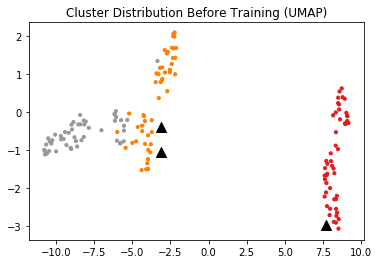

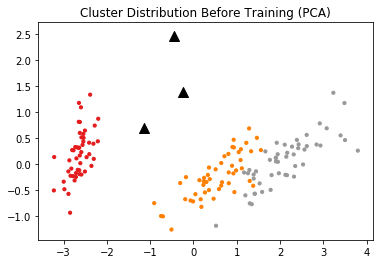

In [5]:
# initial values for the network parameters
init_mu = np.mean(X, axis=0, keepdims=True) + np.random.normal(0, 1, (3, 4))
init_sigma = np.random.normal(1, 0.1, (3, 4))

umap_init_mu = umap_reducer.transform(init_mu)
pca_init_mu = pca_reducer.transform(init_mu)

model = create_model()
model.layers[0].set_weights([init_mu, init_sigma])

plt.title("Cluster Distribution Before Training (UMAP)")
plt.scatter(umap_data[:,0], umap_data[:,1], s=10, c=classes, cmap='Set1')
plt.scatter(umap_init_mu[:,0], umap_init_mu[:,1], s=100, c="k", marker="^")

plt.figure()
plt.title("Cluster Distribution Before Training (PCA)")
plt.scatter(pca_data[:,0], pca_data[:,1], s=10, c=classes, cmap='Set1')
plt.scatter(pca_init_mu[:,0], pca_init_mu[:,1], s=100, c="k", marker="^")

The plots above shows the centers of the clusters visualized using both UMAP and PCA before the model is trained.

In [6]:
def plot_activations(model, inputs):
    fig, axes = plt.subplots(3, 1, squeeze=True)

    for ax, layer in zip(axes, model.layers):
        activation_fn = K.function(model.inputs, [layer.output])
        activation = activation_fn([inputs])[0]

        ax.set_title(layer)
        ax.boxplot(activation.reshape(-1), vert=False)
        
    plt.tight_layout()


def plot_gradients(model, inputs, target):
    loss = -K.sum(target * K.log(model.output) + (1 - target) * K.log(1 - model.output))
    gradient_fn = K.function(model.inputs, K.gradients(loss, model.trainable_weights))
    gradients = gradient_fn([inputs])
    
    fig, axes = plt.subplots(4, 1, squeeze=True)
            
    for ax, param, gradient in zip(axes, model.trainable_weights, gradients):
        ax.set_title(param)
        ax.boxplot(gradient.reshape(-1), vert=False)
        
    plt.tight_layout()
    

#model = create_model()
#model.layers[0].set_weights([init_mu, init_sigma])
#plot_activations(model, X)

The boxplots above show the distributions of the models intermediate activations across all input examples.

In [7]:
#plot_gradients(model, X, Y)

The gradient of each of the model's parameters are plotted above. The gradients were computed using all 150 samples from the dataset. There is no evidence of vanishing gradients.

The black triangles show the locations of the clusters before any training has been done. The initial values were chosen to fit the data and maximize training speed.

W0211 16:46:41.813592 140695479347008 deprecation.py:323] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


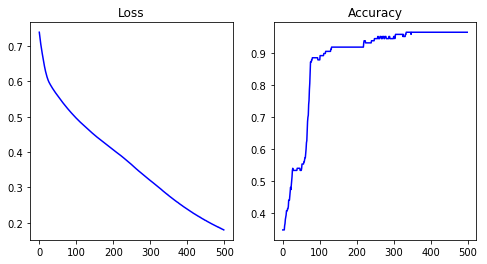

In [8]:
model = create_model()
model.layers[0].set_weights([init_mu, init_sigma])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[keras.metrics.categorical_accuracy])

history = model.fit(
    x=X,
    y=Y,
    batch_size=32,
    epochs=500,
    verbose=0,
    shuffle=True)

fig, axes = plt.subplots(1, 2, figsize=(8,4), squeeze=True)
axes[0].set_title("Loss")
axes[0].plot(history.history["loss"], c="b")
axes[1].set_title("Accuracy")
axes[1].plot(history.history["categorical_accuracy"], c="b")

The model was trained on the Iris dataset for 300 epochs with the loss and accuracy plotted above. No data was used as a validation set, as the performance of the model is not relevant to the purpose of this notebook.

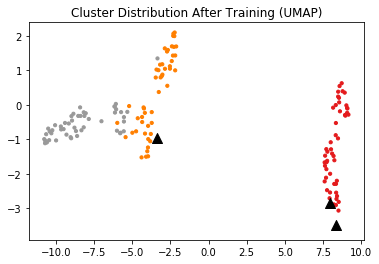

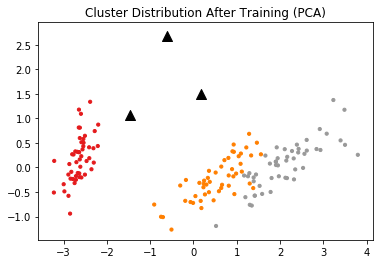

In [9]:
current_mu, current_sigma = model.layers[0].get_weights()
umap_current_mu = umap_reducer.transform(current_mu)
pca_current_mu = pca_reducer.transform(current_mu)

plt.title("Cluster Distribution After Training (UMAP)")
plt.scatter(umap_data[:,0], umap_data[:,1], s=10, c=classes, cmap='Set1')
plt.scatter(umap_current_mu[:,0], umap_current_mu[:,1], s=100, c="k", marker="^")

plt.figure()
plt.title("Cluster Distribution After Training (PCA)")
plt.scatter(pca_data[:,0], pca_data[:,1], s=10, c=classes, cmap='Set1')
plt.scatter(pca_current_mu[:,0], pca_current_mu[:,1], s=100, c="k", marker="^")

Compared to the previous plots it does not appear that the clusters have moved far from their initial locations. Additionally, the clusters do not move to what would be intuitive locations. Despite this, the model was able to fit the dataset well.

In [10]:
#plot_activations(model, X)

As expected, the activations after training now display a higher likelihood to produce an activation of one.

In [11]:
#plot_gradients(model, X, Y)

The model is likely approaching a local minimum as the gradients are getting smaller. The model could be trained further to determine if this changes the locations of the centers.

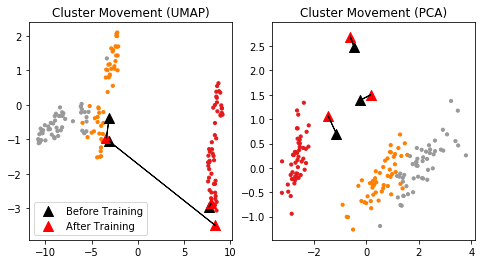

In [12]:
def plot_movements():
    umap_delta_mu = umap_current_mu - umap_init_mu
    pca_delta_mu = pca_current_mu - pca_init_mu

    fig, axes = plt.subplots(1, 2, figsize=(8,4), squeeze=True)
    axes[0].set_title("Cluster Movement (UMAP)")
    axes[0].scatter(umap_data[:,0], umap_data[:,1], s=10, c=classes, cmap='Set1')
    s1 = axes[0].scatter(umap_init_mu[:,0], umap_init_mu[:,1], s=100, c="k", marker="^")
    s2 = axes[0].scatter(umap_current_mu[:,0], umap_current_mu[:,1], s=100, c="r", marker="^")
    for i in range(umap_delta_mu.shape[0]):
        axes[0].arrow(umap_init_mu[i,0], umap_init_mu[i,1], umap_delta_mu[i,0], umap_delta_mu[i,1])
    axes[0].legend([s1, s2], ["Before Training", "After Training"])

    axes[1].set_title("Cluster Movement (PCA)")
    axes[1].scatter(pca_data[:,0], pca_data[:,1], s=10, c=classes, cmap='Set1')
    s1 = axes[1].scatter(pca_init_mu[:,0], pca_init_mu[:,1], s=100, c="k", marker="^")
    s2 = axes[1].scatter(pca_current_mu[:,0], pca_current_mu[:,1], s=100, c="r", marker="^")
    for i in range(umap_delta_mu.shape[0]):
        axes[1].arrow(pca_init_mu[i,0], pca_init_mu[i,1], pca_delta_mu[i,0], pca_delta_mu[i,1])
    #axes[1].legend([s1, s2], ["Before Training", "After Training"])
    

plot_movements()

The plots above show the initial centers (in black) and their final location after training (in red) connected by an arrow.

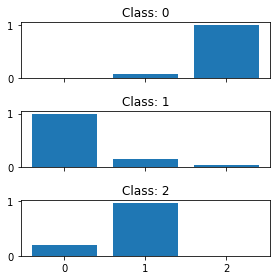

In [29]:
def average_fstrengths():
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(4,4))
    fstrength_fn = K.function(model.inputs, [model.layers[1].output])
    
    fstrength = fstrength_fn([X[classes == 0]])[0]
    ax0.set_title("Class: 0")
    ax0.bar(np.arange(3), np.mean(fstrength, axis=0))
    
    fstrength = fstrength_fn([X[classes == 1]])[0]
    ax1.set_title("Class: 1")
    ax1.bar(np.arange(3), np.mean(fstrength, axis=0))
    
    fstrength = fstrength_fn([X[classes == 2]])[0]
    ax2.set_title("Class: 2")
    ax2.bar(np.arange(3), np.mean(fstrength, axis=0))
    
    plt.setp([ax0, ax1, ax2], xticks=np.arange(3), yticks=[0,1])
    plt.tight_layout()
    
    
average_fstrengths()

The bar charts above show the mean firing strength of each rule for the different classes. Despite the results found in the UMAP and PCA diagrams, each rule, or cluster, seems to have one class where it's firing strength is maximized.

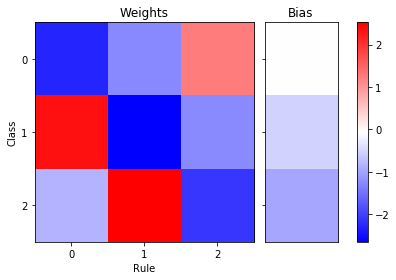

In [26]:
import matplotlib.gridspec as gridspec


kernel, bias = model.layers[2].get_weights()
fig, (ax0, ax1) = plt.subplots(
    1, 2, sharey=True, squeeze=True, gridspec_kw={'width_ratios':[3, 1]})

im0 = ax0.imshow(kernel.T, cmap="bwr")
ax0.set_title("Weights")
ax0.set_ylabel("Class")
ax0.set_xlabel("Rule")
ax0.set_yticks(np.arange(3))
ax0.set_xticks(np.arange(3))

ax1.imshow(bias.reshape(3,1), cmap="bwr", vmin=np.min(kernel), vmax=np.max(kernel))
ax1.set_title("Bias")
ax1.set_xticks([])

plt.tight_layout()
fig.colorbar(im0, ax=[ax0, ax1])

The image above shows how the network uses the firing strenth of each rule to make predictions.

In [15]:
def plot_membership_fns():
    fig, axes = plt.subplots(10, 4, sharex=True, sharey=True)
    mu, sigma = model.layers[0].get_weights()

    for dim in range(4):
        for rule in range(10):
            ax = axes[rule][dim]
            m, s = mu[rule][dim], sigma[rule][dim]

            x = np.linspace(0, 10)
            y = np.exp(-0.5 * np.square((x-m)/s))
            
            ax.plot(x, y)
            ax.set_title("Rule {}, Dim {}".format(rule+1, dim+1))
                    

# does not provide much information
# plot_membership_fns()

The plots above show all 40 membership functions learned by the model.

In [16]:
def print_weights(model):
    mu, sigma = model.layers[0].get_weights()
    weight, bias = model.layers[2].get_weights()
    
    print("Mu:\n", mu, "\n")
    print("Sigma:\n", sigma, "\n")
    print("Kernel:\n", weight, "\n")
    print("Bias:\n", bias, "\n")
    

# no longer needed
# print_weights(model)

Above are the weights of the trained model.

In [17]:
def print_gradients(model, sample):
    # TODO: fix error!!!
    gradient_fn = K.function(model.inputs, K.gradients(model.output, model.trainable_weights))
    gradients = gradient_fn([sample])
    
    print("Gradient Mu:\n", gradients[0], "\n")
    print("Gradient Sigma:\n", gradients[1], "\n")
    print("Gradient Kernel:\n", gradients[2], "\n")
    print("Gradient Bias:\n", gradients[3], "\n")
    

# no longer needed
# print_gradients(model, X)

The gradients of the trained model on all training samples.

In [18]:
def print_weights_and_gradients():
    model = create_model()
    model.layers[0].set_weights([init_mu, init_sigma])
    
    sample = X[0,:].reshape(1,4)
    print("Sample\n", sample, "\n")
    
    print_weights(model)
    print_gradients(model, sample)
    

# no longer needed
# print_weights_and_gradients()

The weights and gradients of an untrained network on a single sample. Will be used to verify that the gradients are correct.

In [19]:
print(X)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.

In [20]:
print(model.predict(X))

[[0.7528958  0.12542191 0.05222809]
 [0.75683844 0.13036218 0.05018079]
 [0.7549337  0.12794665 0.05116361]
 [0.75606465 0.12937582 0.05057812]
 [0.7517452  0.12401992 0.0528363 ]
 [0.74155176 0.11261132 0.05832526]
 [0.7522397  0.12463307 0.05256996]
 [0.7544389  0.12733129 0.05141976]
 [0.7558626  0.12911779 0.05068281]
 [0.7570212  0.13059318 0.05008826]
 [0.7494077  0.12123036 0.05408496]
 [0.75457966 0.12750798 0.05134618]
 [0.7571174  0.13071644 0.0500392 ]
 [0.7534728  0.12612668 0.05192667]
 [0.7338754  0.10438144 0.06290472]
 [0.7100289  0.08356228 0.07818204]
 [0.7390615  0.10977185 0.05982468]
 [0.751753   0.12404889 0.05282542]
 [0.74356973 0.11463663 0.05726334]
 [0.7474569  0.11897597 0.05513498]
 [0.7538482  0.12660554 0.05172518]
 [0.7470583  0.11861801 0.05531487]
 [0.7474505  0.11893931 0.05514935]
 [0.7502208  0.1230931  0.05333018]
 [0.75476706 0.12775108 0.05124584]
 [0.75736654 0.13104457 0.04990947]
 [0.751936   0.12441686 0.05267805]
 [0.7530855  0.1256569  0.05

In [21]:
print(model.predict(X))

[[0.7528958  0.12542191 0.05222809]
 [0.75683844 0.13036218 0.05018079]
 [0.7549337  0.12794665 0.05116361]
 [0.75606465 0.12937582 0.05057812]
 [0.7517452  0.12401992 0.0528363 ]
 [0.74155176 0.11261132 0.05832526]
 [0.7522397  0.12463307 0.05256996]
 [0.7544389  0.12733129 0.05141976]
 [0.7558626  0.12911779 0.05068281]
 [0.7570212  0.13059318 0.05008826]
 [0.7494077  0.12123036 0.05408496]
 [0.75457966 0.12750798 0.05134618]
 [0.7571174  0.13071644 0.0500392 ]
 [0.7534728  0.12612668 0.05192667]
 [0.7338754  0.10438144 0.06290472]
 [0.7100289  0.08356228 0.07818204]
 [0.7390615  0.10977185 0.05982468]
 [0.751753   0.12404889 0.05282542]
 [0.74356973 0.11463663 0.05726334]
 [0.7474569  0.11897597 0.05513498]
 [0.7538482  0.12660554 0.05172518]
 [0.7470583  0.11861801 0.05531487]
 [0.7474505  0.11893931 0.05514935]
 [0.7502208  0.1230931  0.05333018]
 [0.75476706 0.12775108 0.05124584]
 [0.75736654 0.13104457 0.04990947]
 [0.751936   0.12441686 0.05267805]
 [0.7530855  0.1256569  0.05

In [22]:
print(np.argmax(model.predict(X), axis=1).reshape(150,1))

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]]


In [23]:
print(classes.reshape(150,1))

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]]


The values above are used to record the outputs of the classifier.

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(classes, np.argmax(model.predict(X), axis=1))

array([[50,  0,  0],
       [ 0, 48,  2],
       [ 0,  3, 47]])

Generate a confusion matrix for the report.

## Computing the Gradients

In [25]:
def get_keras_gradients(mu, sigma, W, b, x, target):
    model = create_model()
    model.layers[0].set_weights((mu, sigma))
    model.layers[2].set_weights((W, b))
    
    loss = -K.sum(target * K.log(model.output) + (1 - target) * K.log(1 - model.output))
    gradient_fn = K.function(model.inputs, K.gradients(loss, model.trainable_weights))
    return gradient_fn([x])


def np_log_prod(x):
    x = np.sum(np.log(x + 1e-8), axis=2)
    return np.exp(x - np.max(x, axis=1, keepdims=True))


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


mu = init_mu
sigma = init_sigma
W = np.random.normal(0, 0.1, size=(3,3))
b = np.zeros((3))

# forward pass
x = X[0,:].reshape((1,4))
target = Y[0,:].reshape(1,3)

m = np.exp(-0.5 * np.square((x.reshape((-1,1,4)) - mu) / (sigma + 1e-8)))
f = np_log_prod(m)
y = sigmoid(f @ W + b)

# cost
C = -np.sum(target * np.log(y) + (1 - target) * np.log(1 - y))

# backward pass
error = y - target

grad_W = f.T @ error
grad_b = error

grad_f = error @ W.T
grad_logsum = grad_f * f
# this probably can be optimized
grad_logsum[f == 1] = -np.sum((grad_f * f * (f != 1)))
grad_m = grad_logsum.T / m

grad_mu = grad_m * (x - mu) / (sigma * sigma) * m
grad_sigma = grad_m * np.square(x - mu) / (sigma * sigma * sigma) * m

keras_gradients = get_keras_gradients(mu, sigma, W, b, x, target)

# compare the gradients
print(np.allclose(keras_gradients[0], grad_mu, atol=1e-5))
print(np.allclose(keras_gradients[1], grad_sigma, atol=1e-5))
print(np.allclose(keras_gradients[2], grad_W, atol=1e-5))
print(np.allclose(keras_gradients[3], grad_b, atol=1e-5))

True
True
True
True
